In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('./drive/MyDrive/pygoturn/src')
print(os.getcwd())

/content/drive/MyDrive/pygoturn/src


# Fine-Tuning

## Dataset

In [5]:
import torch
from torch.utils.data import Dataset, ConcatDataset
import os
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
import random

class GOTURN_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get all image files inside the root folder
        self.frame_files = sorted([f for f in os.listdir(root_dir) if f.endswith(".bmp")])

        # Load bounding boxes
        bbox_path = os.path.join(os.path.dirname(root_dir), "groundtruth_rect.txt")
        if os.path.exists(bbox_path):
            self.bboxes = np.loadtxt(bbox_path, delimiter=",")
        else:
            raise FileNotFoundError(f"Bounding box file not found at {bbox_path}")

        # If bbox file contains frame indices, remove first column
        if self.bboxes.shape[1] == 5:
            self.bboxes = self.bboxes[:, 1:]

        # Ensure we have enough frames
        if len(self.frame_files) < 2 or len(self.bboxes) < 2:
            raise ValueError("Not enough frames or bounding boxes in the dataset")

        # Store image pairs and corresponding bounding boxes
        self.data = self._load_data()

    def _load_data(self):
        """
        Loads image pairs and bounding boxes for each frame sequence.
        """
        data = []
        for i in range(len(self.frame_files) - 1):
            prev_frame_path = os.path.join(self.root_dir, self.frame_files[i])
            curr_frame_path = os.path.join(self.root_dir, self.frame_files[i + 1])
            bbox = self.bboxes[i + 1]  # Assign bbox of next frame

            data.append((prev_frame_path, curr_frame_path, bbox))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        prev_frame_path, curr_frame_path, bbox = self.data[idx]

        # Read images using OpenCV
        prev_frame = cv2.imread(prev_frame_path)
        curr_frame = cv2.imread(curr_frame_path)

        # Ensure the images are read correctly
        if prev_frame is None or curr_frame is None:
            raise ValueError(f"Error loading image: {prev_frame_path}, {curr_frame_path}")

        # Convert from BGR (OpenCV default) to RGB
        prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
        curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)

        # Convert numpy array to PIL Image
        prev_frame = Image.fromarray(prev_frame)
        curr_frame = Image.fromarray(curr_frame)

        # Apply the transformation if any
        if self.transform:
            # Ensure same random transformation is applied to both frames
            seed = random.randint(0, 99999)  # Generate a random seed
            torch.manual_seed(seed)  # Set the seed for PyTorch transforms
            prev_frame = self.transform(prev_frame)
            torch.manual_seed(seed)  # Reset the seed to ensure same transform
            curr_frame = self.transform(curr_frame)

        return prev_frame, curr_frame, torch.tensor(bbox, dtype=torch.float32)


# Define multiple transformation variations
base_transform = transforms.Compose([
    transforms.Resize((227, 360)),
    transforms.ToTensor(),
])

augmentations = [
    transforms.Compose([
        transforms.Resize((227, 360)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.Resize((227, 360)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.Resize((227, 360)),
        transforms.RandomResizedCrop((227, 360), scale=(0.8, 1.0)),
        transforms.ToTensor(),
    ]),
]

# Create datasets with different transformations
datasets = []
sequences = ["swan", "bag", "bear", "rhino", "book"]

for seq in sequences:
    datasets.append(GOTURN_Dataset(f"../data/OTB/{seq}/img", transform=base_transform))  # Base dataset
    for aug in augmentations:
        datasets.append(GOTURN_Dataset(f"../data/OTB/{seq}/img", transform=aug))  # Augmented datasets

# Concatenate the datasets
combined_dataset = ConcatDataset(datasets)

print(f"Total dataset size: {len(combined_dataset)}")


Total dataset size: 1628


## Fine Tuning


In [7]:
!pip install got10k

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for got10k: filename=got10k-0.1.3-py3-none-any.whl size=43858 sha256=a782463666eaf511f72c465507ac41119cbb4fd62b1ed5d3e8d9cfeec7cdb9ce
  Stored in directory: /root/.cache/pip/wheels/0c/75/da/81b64122700ec083d162c374aba1922beb523d542c429ed8ca
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=bc7e73c2135257ae4694c6f2ab905c2efcf6266d17a74134722825ff06644097
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e36240c1fd00853e92c445e53828c112718ac2defafa3780206a2b80b2e2e03b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built got10k fire wget


In [ ]:
import torch.optim as optim
from goturn import TrackerGOTURN

from torch.utils.data import DataLoader

# Create dataset instance
# dataset = GOTURN_Dataset("../data/OTB/swan/img", transform=None)

# Create DataLoader
train_loader = DataLoader(combined_dataset, batch_size=256, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 200

# Assuming you've already set up the TrackerGOTURN class
tracker = TrackerGOTURN(net_path="./pytorch_goturn.pth")

# Set model to training mode
tracker.net.train()

# Define the optimizer and loss function
optimizer = optim.Adam(tracker.net.parameters(), lr=1e-4)  # You can adjust the learning rate
criterion = torch.nn.SmoothL1Loss()

# Example training loop
for epoch in range(num_epochs):
    for i, (prev_frame, curr_frame, bbox) in enumerate(train_loader):
        prev_frame, curr_frame, bbox = prev_frame.to(device), curr_frame.to(device), bbox.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        pred_bbox = tracker.net(prev_frame, curr_frame)

        # Calculate loss
        loss = criterion(pred_bbox, bbox)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if i % 10 == 0:  # Print every 10 steps
            print(f'Epoch {epoch}/{num_epochs}, Step {i}/{len(train_loader)}, Loss: {loss.item()}')

# Save the fine-tuned model
torch.save(tracker.net.state_dict(), "fine_tuned_goturn.pth")


Epoch 0/200, Step 0/7, Loss: 112.19773864746094
Epoch 1/200, Step 0/7, Loss: 85.07567596435547
Epoch 2/200, Step 0/7, Loss: 52.0325927734375
Epoch 3/200, Step 0/7, Loss: 44.12755584716797
Epoch 4/200, Step 0/7, Loss: 44.479774475097656
Epoch 5/200, Step 0/7, Loss: 40.937110900878906
Epoch 6/200, Step 0/7, Loss: 40.46925354003906
Epoch 7/200, Step 0/7, Loss: 38.788211822509766
Epoch 8/200, Step 0/7, Loss: 38.504249572753906
Epoch 9/200, Step 0/7, Loss: 37.74767303466797
Epoch 10/200, Step 0/7, Loss: 35.50270080566406
Epoch 11/200, Step 0/7, Loss: 27.174121856689453
Epoch 12/200, Step 0/7, Loss: 20.46247100830078
Epoch 13/200, Step 0/7, Loss: 17.59248161315918
Epoch 14/200, Step 0/7, Loss: 16.46763801574707
Epoch 15/200, Step 0/7, Loss: 14.204401016235352
Epoch 16/200, Step 0/7, Loss: 14.353475570678711
Epoch 17/200, Step 0/7, Loss: 13.383399963378906
Epoch 18/200, Step 0/7, Loss: 13.344502449035645
Epoch 19/200, Step 0/7, Loss: 12.368545532226562
Epoch 20/200, Step 0/7, Loss: 12.9926261

In [9]:

# Load the fine-tuned checkpoint
checkpoint = torch.load('./fine_tuned_goturn.pth', map_location=torch.device('cuda'))

# Create a new dictionary to mimic the original model's structure
new_checkpoint = {
    'state_dict': checkpoint
}

# Save the new checkpoint
torch.save(new_checkpoint, './fine_tuned_goturn_reformatted.pth')

# Check the keys in the new checkpoint to ensure it's in the right format
new_checkpoint = torch.load('./fine_tuned_goturn_reformatted.pth', map_location=torch.device('cuda'))
print(new_checkpoint.keys())

dict_keys(['state_dict'])


# Run the test

groundtruth bounding boxes are in **red**.

In [10]:
from test_goturn import run_tracking
# Specify the arguments
data_directory = '../data/OTB/swan'
model_weights = './pytorch_goturn.pth'
model_weights = './fine_tuned_goturn_reformatted.pth'

predicted_boxes, ground_truth_boxes, centroids = run_tracking(data_directory, model_weights)

print(predicted_boxes)
print(ground_truth_boxes)
print(centroids)

[ 67.  38. 253. 190.]
fps: 64.626
[[np.float64(3509.38427734375), np.float64(1321.7454833984375), 427, 240], [np.float64(1992.9263801574707), np.float64(789.6633367538452), 427, 240], [np.float64(1235.5177459716797), np.float64(523.8263411521912), 427, 240], [np.float64(856.3608055114746), np.float64(390.7927157878876), 427, 240], [np.float64(666.782585144043), np.float64(324.3583434820175), 427, 240], [np.float64(572.5590934753418), np.float64(291.33278197050095), 427, 240], [np.float64(525.1347923278809), np.float64(274.5204997956753), 427, 240], [np.float64(501.31900215148926), np.float64(266.18996791541576), 427, 240], [np.float64(489.0510835647583), np.float64(261.7318676933646), 427, 240], [np.float64(483.1129994392395), np.float64(259.830137681216), 427, 240], [np.float64(479.3017580509186), np.float64(258.46980688534677), 427, 240], [np.float64(477.7220650911331), np.float64(258.04771624784917), 427, 240], [np.float64(476.95131880044937), np.float64(257.8437290727161), 427, 240

[1926.9370124630436, 1122.9230828511809, 720.779092371581, 519.0553920344148, 417.61465491526997, 366.85317226378186, 339.7123783437984, 326.2644632809402, 318.4273857569415, 315.29351404683223, 312.1602152741441, 309.4757664179863, 307.91638475404324, 306.35967423928366, 305.039341724965, 304.2059335384502, 302.49132218957953, 302.1671722738921, 302.9331609447866, 302.7936591145858, 304.4343114696502, 304.4343114696502, 305.8144862494254, 306.2747949146322, 308.11726663723346, 309.30769469898416, 309.7692689728921, 311.3462702522707, 312.0, 311.2703808588283, 312.65396207308805, 312.1926488564393, 311.7314549415891, 311.7314549415891, 311.2703808588283, 312.1926488564393, 312.1926488564393, 312.1926488564393, 311.0771608459869, 311.46428366668306, 311.46428366668306, 311.0036173423068, 310.474234035612, 310.6710478947145, 310.60787176116446, 310.34859432580004, 311.6652852019294, 311.61033358988595, 312.92970456637704]


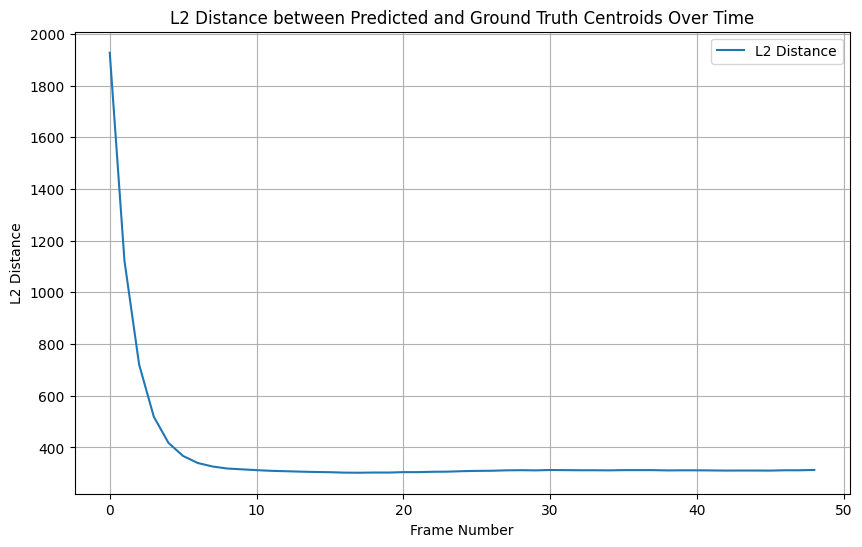

In [11]:
import matplotlib.pyplot as plt

# Calculate the ground truth centroids
groundtruth_centroids = []
for i in range(len(ground_truth_boxes)):
    groundtruth_centroid = (ground_truth_boxes[i][0] + ground_truth_boxes[i][2] / 2,
                            ground_truth_boxes[i][1] + ground_truth_boxes[i][3] / 2)
    groundtruth_centroids.append(groundtruth_centroid)

# Calculate the L2 distance between corresponding centroids
def L2(a, b):
    # Calculate the Euclidean distance between two points a and b
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

# Compute L2 distances for each frame
l2_distances = [L2(centroids[i], groundtruth_centroids[i]) for i in range(len(centroids))]
print(l2_distances)
# Plot the L2 distances over time (frame number)
plt.figure(figsize=(10, 6))
plt.plot(range(len(l2_distances)), l2_distances, label="L2 Distance")
plt.xlabel("Frame Number")
plt.ylabel("L2 Distance")
plt.title("L2 Distance between Predicted and Ground Truth Centroids Over Time")
plt.grid(True)
plt.legend()
plt.show()